In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import thư viện cần thiết
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# 3. Định nghĩa đường dẫn
train_images_dir = "/content/drive/MyDrive/BTL/Labeled/train/images"
train_labels_dir = "/content/drive/MyDrive/BTL/Labeled/train/labels"

valid_images_dir = "/content/drive/MyDrive/BTL/Labeled/valid/images"
valid_labels_dir = "/content/drive/MyDrive/BTL/Labeled/valid/labels"

test_images_dir  = "/content/drive/MyDrive/BTL/Labeled/test/images"
test_labels_dir  = "/content/drive/MyDrive/BTL/Labeled/test/labels"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 4. Các thông số
IMAGE_SIZE = 256
NUM_CLASSES = 4  # [Glioma, Meningioma, No Tumor, Pituitary]
# Giả sử: 0=Glioma, 1=Meningioma, 2=No Tumor, 3=Pituitary

# 5. Hàm tạo mask từ file
def create_mask_from_txt(label_file_path, image_size):
    """
    Đọc file TXT YOLO: class x_center y_center width height (giá trị normalized)
    Nếu file không tồn tại/rỗng => coi như 'No Tumor' (2).
    """
    mask = np.full((image_size, image_size), 2, dtype=np.uint8)  # Mặc định = 2 (No Tumor)

    if not os.path.exists(label_file_path):
        return mask

    with open(label_file_path, 'r') as f:
        lines = f.read().strip().splitlines()

    if len(lines) == 0:
        return mask

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        cls, x_center, y_center, w, h = parts
        cls = int(cls)

        x_center = float(x_center) * image_size
        y_center = float(y_center) * image_size
        w = float(w) * image_size
        h = float(h) * image_size

        x1 = int(max(x_center - w/2, 0))
        y1 = int(max(y_center - h/2, 0))
        x2 = int(min(x_center + w/2, image_size-1))
        y2 = int(min(y_center + h/2, image_size-1))

        mask[y1:y2, x1:x2] = cls

    return mask


In [ ]:
# 6. Hàm load dataset
def load_dataset_txt(images_dir, labels_dir, image_size=256):
    image_files = sorted(os.listdir(images_dir))
    label_files = sorted(os.listdir(labels_dir))

    images = []
    labels = []

    for img_file, label_file in zip(image_files, label_files):
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, label_file)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (image_size, image_size))
        img = img.astype(np.float32) / 255.0
        images.append(img[..., np.newaxis])  # (H,W,1)

        mask = create_mask_from_txt(label_path, image_size)
        labels.append(mask)  # (H,W)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [ ]:
# 7. Load dữ liệu train, valid, test
train_images, train_labels = load_dataset_txt(train_images_dir, train_labels_dir, IMAGE_SIZE)
valid_images, valid_labels = load_dataset_txt(valid_images_dir, valid_labels_dir, IMAGE_SIZE)
test_images,  test_labels  = load_dataset_txt(test_images_dir,  test_labels_dir,  IMAGE_SIZE)

print("Train:", train_images.shape, train_labels.shape)
print("Valid:", valid_images.shape, valid_labels.shape)
print("Test:", test_images.shape, test_labels.shape)

Train: (1695, 256, 256, 1) (1695, 256, 256)
Valid: (502, 256, 256, 1) (502, 256, 256)
Test: (246, 256, 256, 1) (246, 256, 256)


In [ ]:
# 8. Giảm kích thước dataset
MAX_TRAIN = 200  # Chọn 200 ảnh cho train
MAX_VALID = 250   # Chọn 50 ảnh cho valid
MAX_TEST  = 250   # Chọn 50 ảnh cho test

train_images = train_images[:MAX_TRAIN]
train_labels = train_labels[:MAX_TRAIN]

valid_images = valid_images[:MAX_VALID]
valid_labels = valid_labels[:MAX_VALID]

test_images  = test_images[:MAX_TEST]
test_labels  = test_labels[:MAX_TEST]

print("Reduced Train:", train_images.shape)
print("Reduced Valid:", valid_images.shape)
print("Reduced Test:", test_images.shape)


Reduced Train: (200, 256, 256, 1)
Reduced Valid: (250, 256, 256, 1)
Reduced Test: (246, 256, 256, 1)


In [ ]:
# 9. Data Augmentation
def random_augment(img, mask):
    """
    img: (H,W,1) float32
    mask: (H,W) uint8 (giá trị 0..3)
    """
    # Flip left-right
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        # Thêm kênh cho mask
        mask = tf.expand_dims(mask, axis=-1)  # (H,W) -> (H,W,1)
        mask = tf.image.flip_left_right(mask)
        mask = tf.squeeze(mask, axis=-1)

    # Flip up-down
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.flip_up_down(mask)
        mask = tf.squeeze(mask, axis=-1)

    return img, mask

# Tạo tf.data cho train
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))
train_ds = train_ds.map(random_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# Tạo tf.data cho valid
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_ds = valid_ds.batch(8).prefetch(tf.data.AUTOTUNE)


In [ ]:
# 10. Xây dựng U-Net đa lớp
from tensorflow.keras import layers, Model

def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet_multiclass(input_shape, num_classes):
    inp = layers.Input(input_shape)
    s1, p1 = encoder_block(inp, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b = conv_block(p4, 1024)

    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    out = layers.Conv2D(num_classes, 1, activation="softmax")(d4)
    return Model(inp, out, name="U-Net")

model = build_unet_multiclass((IMAGE_SIZE, IMAGE_SIZE, 1), NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      4,719,104 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 34,512,388 (131.65 MB)

 Trainable params: 34,512,388 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 10. Huấn luyện mô hình
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS
)

# 11. Dự đoán trên tập test
test_pred = model.predict(test_images)  # shape (N,H,W,4)
test_pred_labels = np.argmax(test_pred, axis=-1)  # (N,H,W)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1303s 52s/step - accuracy: 0.9552 - loss: 1.2841 - val_accuracy: 0.9679 - val_loss: 0.5760
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1323s 52s/step - accuracy: 0.9821 - loss: 0.2663 - val_accuracy: 0.9679 - val_loss: 0.4875
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1324s 54s/step - accuracy: 0.9809 - loss: 0.0838 - val_accuracy: 0.9679 - val_loss: 0.4212
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1289s 51s/step - accuracy: 0.9825 - loss: 0.0721 - val_accuracy: 0.9679 - val_loss: 0.3487
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1264s 51s/step - accuracy: 0.9825 - loss: 0.0672 - val_accuracy: 0.9679 - val_loss: 0.3252
Epoch 6/50
19/25 ━━━━━━━━━━━━━━━━━━━━ 3:41 37s/step - accuracy: 0.9815 - loss: 0.0707

In [ ]:
# 12. Hàm hiển thị 3 ảnh: Brain MRI, Mask, MRI with Mask
def visualize_three_images(index):
    """
    1) Brain MRI (ảnh gốc)
    2) Mask (nền đen, vùng khối u trắng)
    3) MRI with Mask (chồng màu đỏ)

    Ở đây, ta coi vùng khối u = pixel != 2 (No Tumor).
    """
    img = test_images[index].squeeze()            # (256,256)
    label = test_labels[index]                    # (256,256)
    pred_label = test_pred_labels[index]          # (256,256)

    # 1) Ảnh gốc
    brain_mri = img  # (256,256) grayscale [0..1]

    # 2) Tạo mask nhị phân: =1 nếu pixel !=2
    #   => Vùng u = [0,1,3], Nền = 2 => 0
    mask_binary = (pred_label != 2).astype(np.uint8)

    # 3) Tạo overlay màu đỏ
    #   Chuyển ảnh gốc sang BGR
    mri_bgr = cv2.cvtColor((brain_mri*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    overlay = np.zeros_like(mri_bgr)
    overlay[mask_binary==1] = (0,0,255)  # đỏ
    alpha = 0.5
    mri_with_mask = cv2.addWeighted(mri_bgr, 1.0, overlay, alpha, 0)

    # Subplot
    plt.figure(figsize=(12,4))

    # Subplot 1: Brain MRI
    plt.subplot(1,3,1)
    plt.imshow(brain_mri, cmap='gray')
    plt.title("Brain MRI")
    plt.axis("off")

    # Subplot 2: Mask (trắng trên nền đen)
    #   => mask_binary=1 => trắng, 0 => đen
    plt.subplot(1,3,2)
    plt.imshow(mask_binary, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    # Subplot 3: MRI with Mask (overlay đỏ)
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(mri_with_mask, cv2.COLOR_BGR2RGB))
    plt.title("MRI with Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

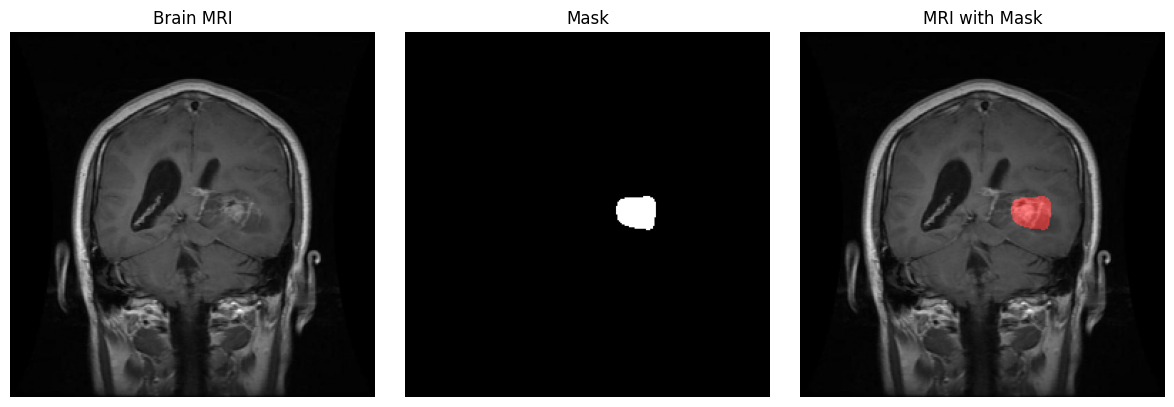

In [ ]:
# 13. Hiển thị kết quả
# Thử hiển thị ảnh thứ x (bạn thay index tuỳ ý)
visualize_three_images(15)